In [1]:
import numpy as np
MY_DEPTH = 10
from scipy.optimize import minimize_scalar
import re

def lp_minimizer(x, p):
    """
    Find the Lp minimizer for the given 1D vector x and a specified value of p.
    Returns (minimizer, minimal_value).
    """
    def objective(m):
        return np.sum(np.abs(x - m) ** p)
    result = minimize_scalar(objective, method='bounded', bounds=(np.min(x), np.max(x)))
    return result.x, result.fun

class DecisionTreeRegressor:
    def __init__(
        self,
        min_samples_split=2,
        max_depth=float('inf'),
        error_method='variance',
        cyclic_padding=0,
        loss_norm=2,
        *,
        # Decoupled split options
        use_decoupled_split=False,
        split_dim_criterion='variance',     # {'variance','minimax'}
        split_loc_criterion='variance',     # {'variance','minimax'}
        split_order='dimension_first'       # {'dimension_first','location_first','joint'}
    ):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth if isinstance(max_depth, int) else float('inf')
        self.root = None
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm

        # Legacy error_method handling (backward compatible)
        if isinstance(error_method, list):
            if isinstance(max_depth, int) and len(error_method) != max_depth:
                raise ValueError("The error_method list must be the same length as max_depth (when max_depth is an int).")
            if not all(method in ['variance', 'minimax', 'cyclic_minimax', 'weighted_variance','xminimizer'] for method in error_method):
                raise ValueError("Error_method list can only contain 'variance', 'minimax', 'xminimizer', 'weighted_variance', or 'cyclic_minimax'.")
            self.error_method = error_method
        elif error_method in ['variance', 'minimax', 'cyclic_minimax', 'weighted_variance','xminimizer']:
            if isinstance(max_depth, int):
                self.error_method = [error_method] * max_depth
            else:
                self.error_method = [error_method]  # safe fallback
        else:
            raise ValueError("Invalid error_method. Must be 'variance', 'minimax', 'cyclic_minimax', 'weighted_variance', 'xminimizer', or a list of these.")

        # New: decoupled split config
        self.use_decoupled_split = use_decoupled_split
        if split_dim_criterion not in ('variance', 'minimax'):
            raise ValueError("split_dim_criterion must be 'variance' or 'minimax'.")
        if split_loc_criterion not in ('variance', 'minimax'):
            raise ValueError("split_loc_criterion must be 'variance' or 'minimax'.")
        if split_order not in ('dimension_first', 'location_first', 'joint'):
            raise ValueError("split_order must be 'dimension_first', 'location_first', or 'joint'.")
        self.split_dim_criterion = split_dim_criterion
        self.split_loc_criterion = split_loc_criterion
        self.split_order = split_order

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None, is_leaf=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left is None and self.right is None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        # NOTE: fit() returns the node (legacy). Assign with: self.root = self.fit(X, y)
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        # Decoupled split path
        if self.use_decoupled_split:
            best_feature, best_threshold = self.find_best_split_decoupled(
                X, y,
                dim_criterion=self.split_dim_criterion,
                loc_criterion=self.split_loc_criterion,
                order=self.split_order
            )
        else:
            # Legacy path
            idx = depth if depth < len(self.error_method) else 0
            current_error_method = self.error_method[idx]
            if current_error_method == 'cyclic_minimax':
                best_feature, best_threshold = self.cyclic_minimax_split(X, y, depth)
            elif current_error_method == 'xminimizer':
                best_feature, best_threshold = self.find_best_split_xminimizer(X, y)
            else:
                best_feature, best_threshold = self.find_best_split_legacy(X, y, current_error_method)

        if best_feature is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)

    # ---------- NEW: decoupled (and joint) split selection ----------
    def find_best_split_decoupled(self, X, y, dim_criterion, loc_criterion, order):
        num_features = X.shape[1]

        def best_threshold_for_feature(feature_index, criterion):
            _, thr, err = self.evaluate_splits(X, y, feature_index, criterion)
            return thr, err

        if order == 'joint':
            # Joint selection under a single criterion (must match)
            #if dim_criterion != loc_criterion:
            #    raise ValueError("For split_order='joint', split_dim_criterion and split_loc_criterion must be identical.")
            best_feat = None
            best_thr = None
            best_err = float('inf')
            for f in range(num_features):
                _, thr, err = self.evaluate_splits(X, y, f, dim_criterion)
                if err < best_err:
                    best_err = err
                    best_feat = f
                    best_thr = thr
            if best_feat is None or best_thr is None:
                return None, None
            return best_feat, best_thr

        if order == 'dimension_first':
            # 1) Pick feature by its best achievable error under dim_criterion.
            best_feat = None
            best_feat_err = float('inf')
            for f in range(num_features):
                _, _, err = self.evaluate_splits(X, y, f, dim_criterion)
                if err < best_feat_err:
                    best_feat_err = err
                    best_feat = f
            if best_feat is None or not np.isfinite(best_feat_err):
                return None, None
            # 2) On that feature, pick threshold under loc_criterion.
            thr, _ = best_threshold_for_feature(best_feat, loc_criterion)
            return best_feat, thr

        else:  # 'location_first'
            # 1) Per feature, pick threshold under loc_criterion.
            # 2) Among those, choose the feature minimizing the dim_criterion.
            best_feat = None
            best_thr = None
            best_score = float('inf')
            for f in range(num_features):
                thr_f, _ = best_threshold_for_feature(f, loc_criterion)
                if thr_f is None:
                    continue
                left_idx = X[:, f] <= thr_f
                right_idx = ~left_idx
                score = self.calculate_error(y, left_idx, right_idx, dim_criterion)
                if score < best_score:
                    best_score = score
                    best_feat = f
                    best_thr = thr_f
            if best_feat is None or best_thr is None:
                return None, None
            return best_feat, best_thr

    # ---------- legacy helpers kept (minimal changes) ----------
    def find_best_split_legacy(self, X, y, error_method):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            _, threshold, error = self.evaluate_splits(X, y, feature_index, error_method)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold
        return best_feature, best_threshold

    def find_best_split_xminimizer(self, X, y):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            Xcoord = X[:, feature_index].ravel()
            threshold, error = lp_minimizer(Xcoord, self.loss_norm)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold
        return best_feature, best_threshold

    def cyclic_minimax_split(self, X, y, depth):
        num_features = X.shape[1]
        feature_index = (self.cyclic_padding + depth) % num_features
        _, best_threshold, _ = self.evaluate_splits(X, y, feature_index, 'minimax')
        return feature_index, best_threshold

    def evaluate_splits(self, X, y, feature_index, error_method):
        thresholds = np.unique(X[:, feature_index])
        min_error = float('inf')
        best_threshold = None
        for threshold in thresholds:
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            error = self.calculate_error(y, left_indices, right_indices, error_method)
            if error < min_error:
                min_error = error
                best_threshold = threshold
        return feature_index, best_threshold, min_error

    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)

    def calculate_error(self, y, left_indices, right_indices, error_method):
        # invalidate trivial splits
        if np.sum(left_indices) <= 1 or np.sum(right_indices) <= 1:
            return np.inf

        if error_method in ('variance', 'minimax', 'cyclic_minimax'):
            if self.loss_norm == 2:
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            if error_method in ('minimax', 'cyclic_minimax'):
                return max(left_error, right_error)
            else:  # 'variance'
                return left_error + right_error

        elif error_method == 'weighted_variance':
            left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            # Keep legacy behavior (n * SSE) for minimal change
            return np.sum(left_indices) * left_error + np.sum(right_indices) * right_error

        return np.inf  # fallback

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return predictions

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def prune(self, node=None):
        if node is None:
            node = self.root
        if node is None:
            return
        if node.is_leaf:
            return

        if node.left.is_leaf and node.right.is_leaf:
            original_error = self.node_error(node)
            original_leaves = self.count_leaves()
            # try pruning
            node_is_leaf_backup = node.is_leaf
            left_backup, right_backup = node.left, node.right
            node.is_leaf = True
            node.value = node.targets.mean()
            pruned_error = self.node_error(node)
            complexity_alpha = 0.1
            pruned_leaves = original_leaves - 1  # two leaves -> one
            original_complexity = original_error + complexity_alpha * original_leaves
            pruned_complexity = pruned_error + complexity_alpha * pruned_leaves
            if pruned_complexity > original_complexity:
                # revert
                node.is_leaf = node_is_leaf_backup
                node.left, node.right = left_backup, right_backup
                node.value = None
            else:
                node.left = None
                node.right = None

        if not node.is_leaf:
            self.prune(node.left)
            self.prune(node.right)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()

    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root
        if node is None:
            print("(empty tree)")
            return
        if node.is_leaf:
            print(f"{'    ' * depth}Leaf: Predict = {node.value:.4f}")
        else:
            print(f"{'    ' * depth}Node: X[{node.feature_index}] <= {node.threshold:.4f}, "
                  f"Error = {self.node_error(node):.4f}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def count_leaves(self, node=None):
        if node is None:
            node = self.root
        if node is None:
            return 0
        if node.is_leaf:
            return 1
        else:
            return self.count_leaves(node.left) + self.count_leaves(node.right)


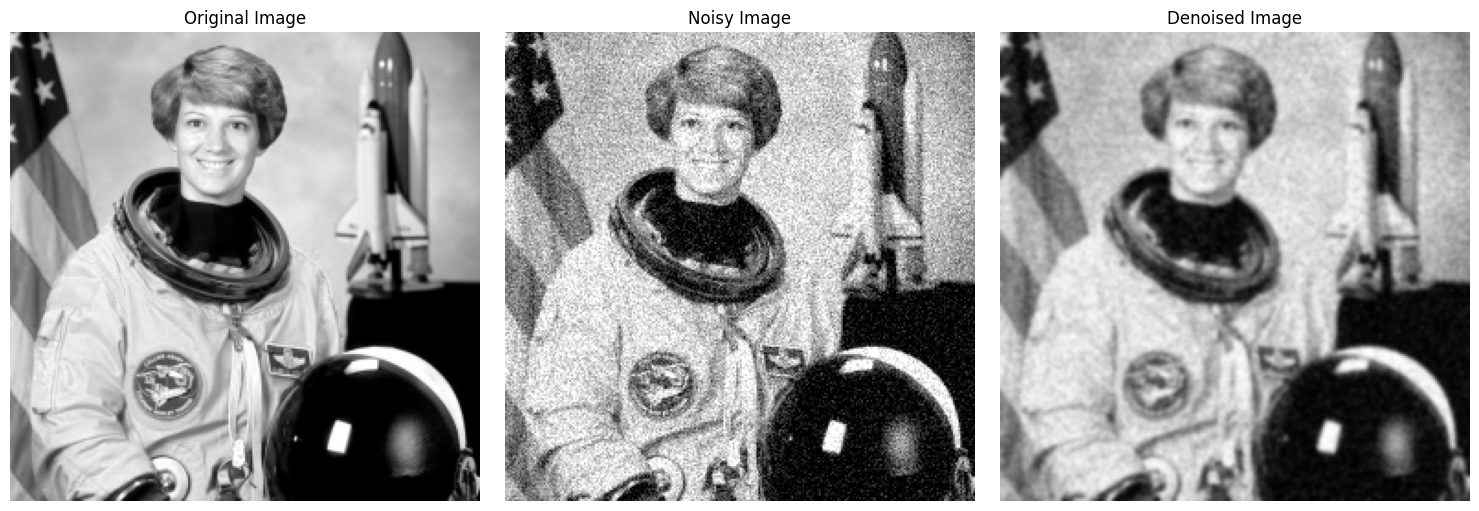

10


/tmp/ipykernel_227040/2318055820.py:81: RuntimeWarning: Mean of empty slice.
  node = self.Node(value=y.mean(), data=X, targets=y)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [2]:
 import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, color, transform

def load_image(filepath, height=64, width=64):
    # Load the image
    image = io.imread(filepath)[:,:,0]
    
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Resize the image if height and width are provided
    if height is not None and width is not None:
        image = transform.resize(image, (height, width), anti_aliasing=True)
    
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())
    
    return image

# Add Gaussian noise to the image
def add_noise(image, mean=0, std=1.):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip values to [0, 1] range

# Denoise the image using Gaussian filter
def denoise_image(noisy_image, sigma=1):
    denoised_image = ndimage.gaussian_filter(noisy_image, sigma=sigma)
    return denoised_image

 

# Load original image
original_image = load_image('astronaut.jpeg',256,256)

# Add noise
noisy_image = add_noise(original_image,0.,.1)

# Denoise the image
denoised_image = denoise_image(noisy_image)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title('Denoised Image')
axes[2].axis('off')

plt.tight_layout()
plt.show() 

#Better visualization
original_image = np.rot90(original_image, k=-1) 
noisy_image  = np.rot90(noisy_image, k=-1) 
height, width = original_image.shape
# Generating a 2D grid of features
x1 = np.linspace(0, 1, height)
x2 = np.linspace(0, 1, width)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

 

y = noisy_image.flatten(order='F')

vari1=[]
wvari1=[]
mini1=[]
cyclic1=[]
vari2=[]
wvari2=[]
mini2=[]
cyclic2=[]

logvari=[]
logmini=[]
for depth in [MY_DEPTH]:
    print(depth)
    # Prepare the mesh grid for predictions and visualization
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_new = original_image.flatten(order='F')  # Slightly less noise for cleaner function visualization
    # Assuming the DecisionTreeRegressor class has already been imported and is available
    tree1 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=1)
    tree1.root = tree1.fit(X, y)
    # Make predictions on the grid
    predictions1 = tree1.predict(X_new)
    predictions1 = np.asarray(predictions1).reshape(X1.shape)  # Reshape to 2D grid
    logvari.append(np.log(np.mean((predictions1.ravel()-y_new)**2)))
    vari1.append(np.mean((predictions1.ravel()-y_new)**2))

    tree1b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='weighted_variance',loss_norm=1)
    tree1b.root = tree1b.fit(X, y)
    # Make predictions on the grid
    predictions1b = tree1b.predict(X_new)
    predictions1b = np.asarray(predictions1b).reshape(X1.shape)  # Reshape to 2D grid
    wvari1.append(np.mean((predictions1b.ravel()-y_new)**2))

    tree2 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=1)
    tree2.root = tree2.fit(X, y)
    # Make predictions on the grid
    predictions2 = tree2.predict(X_new)
    predictions2 = np.asarray(predictions2).reshape(X1.shape)  # Reshape to 2D grid
    mini1.append(np.mean((predictions2.ravel()-y_new)**2))

    tree2b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='cyclic_minimax',loss_norm=1)
    tree2b.root = tree2b.fit(X, y)
    # Make predictions on the grid
    predictions2b = tree2b.predict(X_new)
    predictions2b = np.asarray(predictions2b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic1.append(np.mean((predictions2b.ravel()-y_new)**2))

    tree2c = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='xminimizer',loss_norm=1)
    tree2c.root = tree2c.fit(X, y)
    # Make predictions on the grid
    predictions2c = tree2c.predict(X_new)
    predictions2c = np.asarray(predictions2c).reshape(X1.shape)  # Reshape to 2D grid
    #cyclic1.append(np.mean((predictions2b.ravel()-y_new)**2))



    tree3 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='variance',loss_norm=2)
    tree3.root = tree3.fit(X, y)
    # Make predictions on the grid
    predictions3 = tree3.predict(X_new)
    predictions3 = np.asarray(predictions3).reshape(X1.shape)  # Reshape to 2D grid
    vari2.append(np.mean((predictions3.ravel()-y_new)**2))

    tree3b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='weighted_variance',loss_norm=2)
    tree3b.root = tree3b.fit(X, y)
    # Make predictions on the grid
    predictions3b = tree3b.predict(X_new)
    predictions3b = np.asarray(predictions3b).reshape(X1.shape)  # Reshape to 2D grid
    wvari2.append(np.mean((predictions3b.ravel()-y_new)**2))

    tree4 = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='minimax',loss_norm=2)
    tree4.root = tree4.fit(X, y)
    # Make predictions on the grid
    predictions4 = tree4.predict(X_new)
    predictions4 = np.asarray(predictions4).reshape(X1.shape)  # Reshape to 2D grid
    mini2.append(np.mean((predictions4.ravel()-y_new)**2))

    tree4b = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='cyclic_minimax',loss_norm=2)
    tree4b.root = tree4b.fit(X, y)
    # Make predictions on the grid
    predictions4b = tree4b.predict(X_new)
    predictions4b = np.asarray(predictions4b).reshape(X1.shape)  # Reshape to 2D grid
    cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

    tree4c = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='xminimizer',loss_norm=2)
    tree4c.root = tree4c.fit(X, y)
    # Make predictions on the grid
    predictions4c = tree4c.predict(X_new)
    predictions4c = np.asarray(predictions4c).reshape(X1.shape)  # Reshape to 2D grid
    #cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

    tree4d = DecisionTreeRegressor(min_samples_split=2, max_depth=depth, error_method='xminimizer',loss_norm=3)
    tree4d.root = tree4d.fit(X, y)
    # Make predictions on the grid
    predictions4d = tree4d.predict(X_new)
    predictions4d = np.asarray(predictions4d).reshape(X1.shape)  # Reshape to 2D grid
    #cyclic2.append(np.mean((predictions4b.ravel()-y_new)**2))

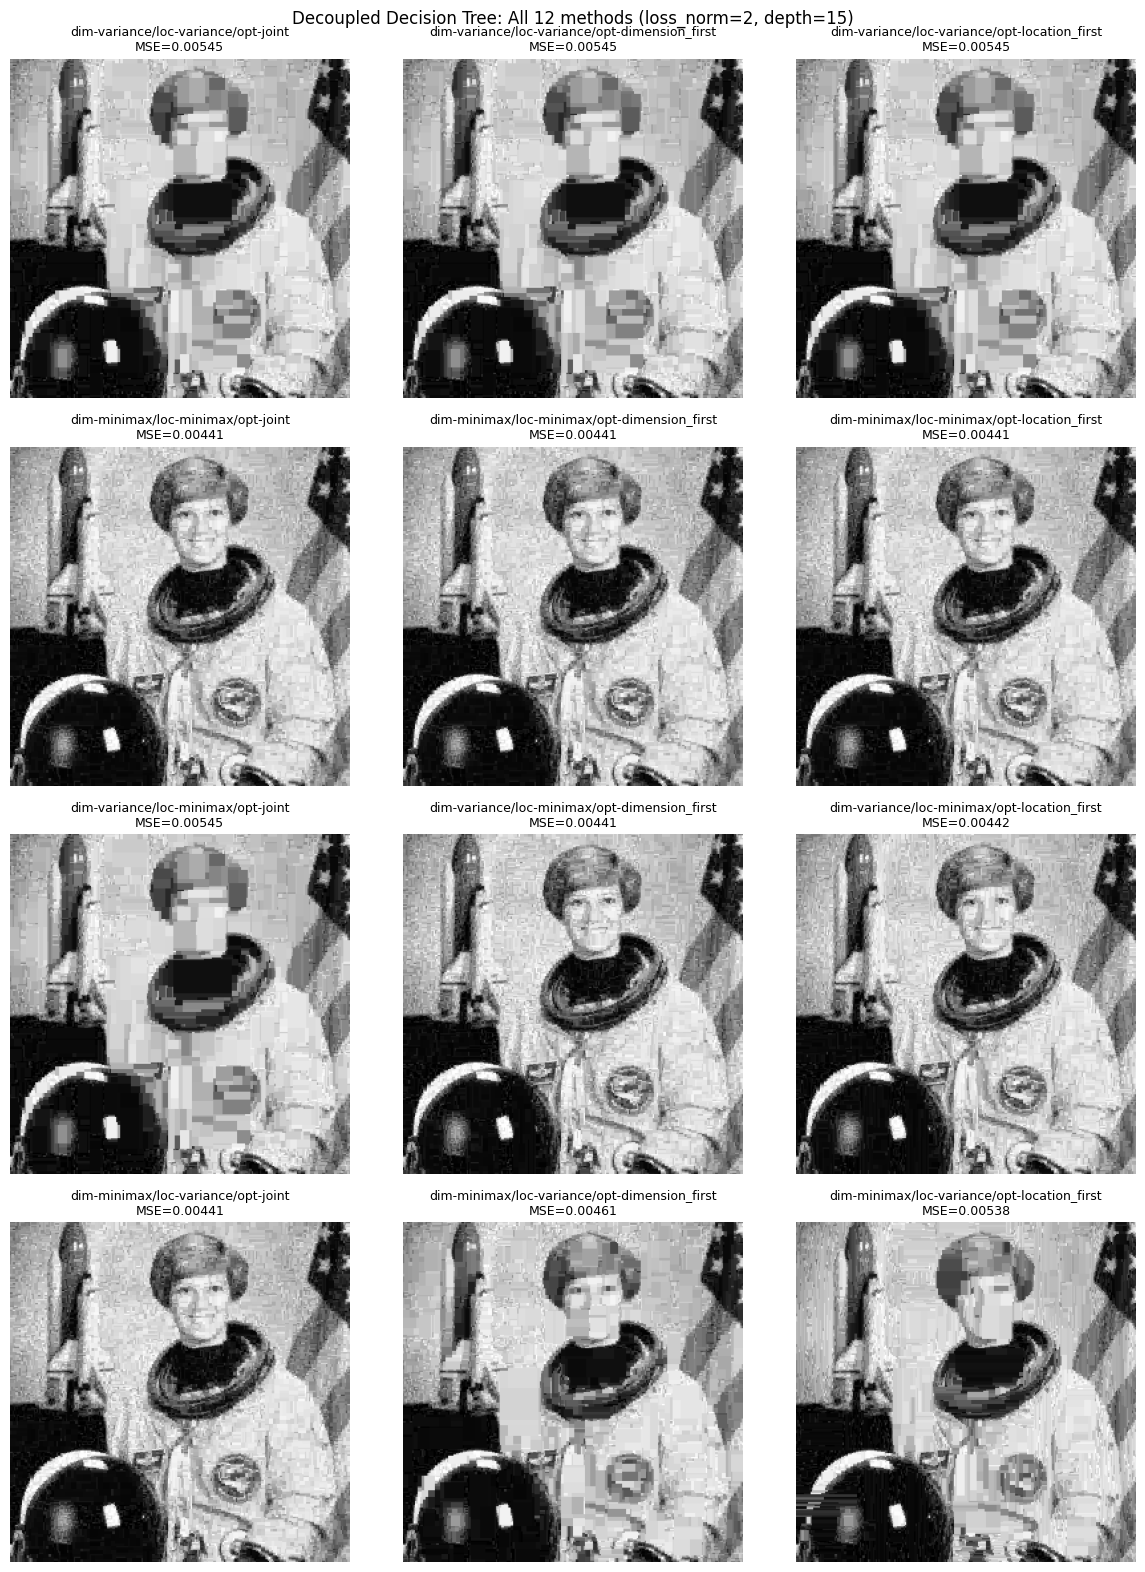

In [3]:
# ===== Compare all 10 decoupled options in a grid and show MSEs in titles =====
# Make sure X1, X2, X, y, original_image exist (as in your code).
# We'll use MSE against the original_image.

# Inputs for prediction and target
X_new = np.c_[X1.ravel(), X2.ravel()]
y_new = original_image.flatten(order='F')

# Choose your loss norm for tree fitting (2 = MSE-like, 1 = LAD-like split losses)
LOSS_NORM = 2
DEPTH = 15

decoupled_options = [
    # same-criterion (3 ways each)
    ('variance', 'variance', 'joint'),
    ('variance', 'variance', 'dimension_first'),
    ('variance', 'variance', 'location_first'),
    ('minimax',  'minimax',  'joint'),
    ('minimax',  'minimax',  'dimension_first'),
    ('minimax',  'minimax',  'location_first'),
    # mixed-criterion (joint invalid)
    ('variance', 'minimax',  'joint'),
    ('variance', 'minimax',  'dimension_first'),
    ('variance', 'minimax',  'location_first'),
    ('minimax',  'variance', 'joint'),
    ('minimax',  'variance', 'dimension_first'),
    ('minimax',  'variance', 'location_first'),

]

results = []  # list of (label, mse, pred_img)

for c_dim, c_loc, order in decoupled_options:
    label = f"dim-{c_dim}/loc-{c_loc}/opt-{order}"
    tree = DecisionTreeRegressor(
        min_samples_split=2,
        max_depth=DEPTH,
        use_decoupled_split=True,
        split_dim_criterion=c_dim,
        split_loc_criterion=c_loc,
        split_order=order,
        loss_norm=LOSS_NORM,
    )
    tree.root = tree.fit(X, y)
    preds = np.asarray(tree.predict(X_new)).reshape(X1.shape)
    mse = np.mean((preds.ravel() - y_new) ** 2)
    results.append((label, mse, preds))

# Optional: sort by MSE so the best appears first
#results.sort(key=lambda t: t[1])

# ---- Plot grid: 2 rows x 5 columns ----
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
for i, (label, mse, img) in enumerate(results):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    img0 = np.rot90(img, k=-1) 
    img0 = np.rot90(img0, k=-1) 
    ax.imshow(img0, cmap='gray')
    ax.set_title(f"{label}\nMSE={mse:.5f}", fontsize=9)
    ax.axis('off')

plt.suptitle(f"Decoupled Decision Tree: All 12 methods (loss_norm={LOSS_NORM}, depth={DEPTH})", y=0.98)
plt.tight_layout()
plt.show()


Training random forests with depth 10...
Training Random Forest with pure Variance Split L2 trees...
Training Random Forest with pure Minimax Split L2 trees...
Training Random Forest with pure Cyclic Minimax L2 trees...
Training Random Forest with random features + Variance Split...
Training Random Forest with random features + Minimax Split...
Training Random Forest with random features + Cyclic Minimax Split...


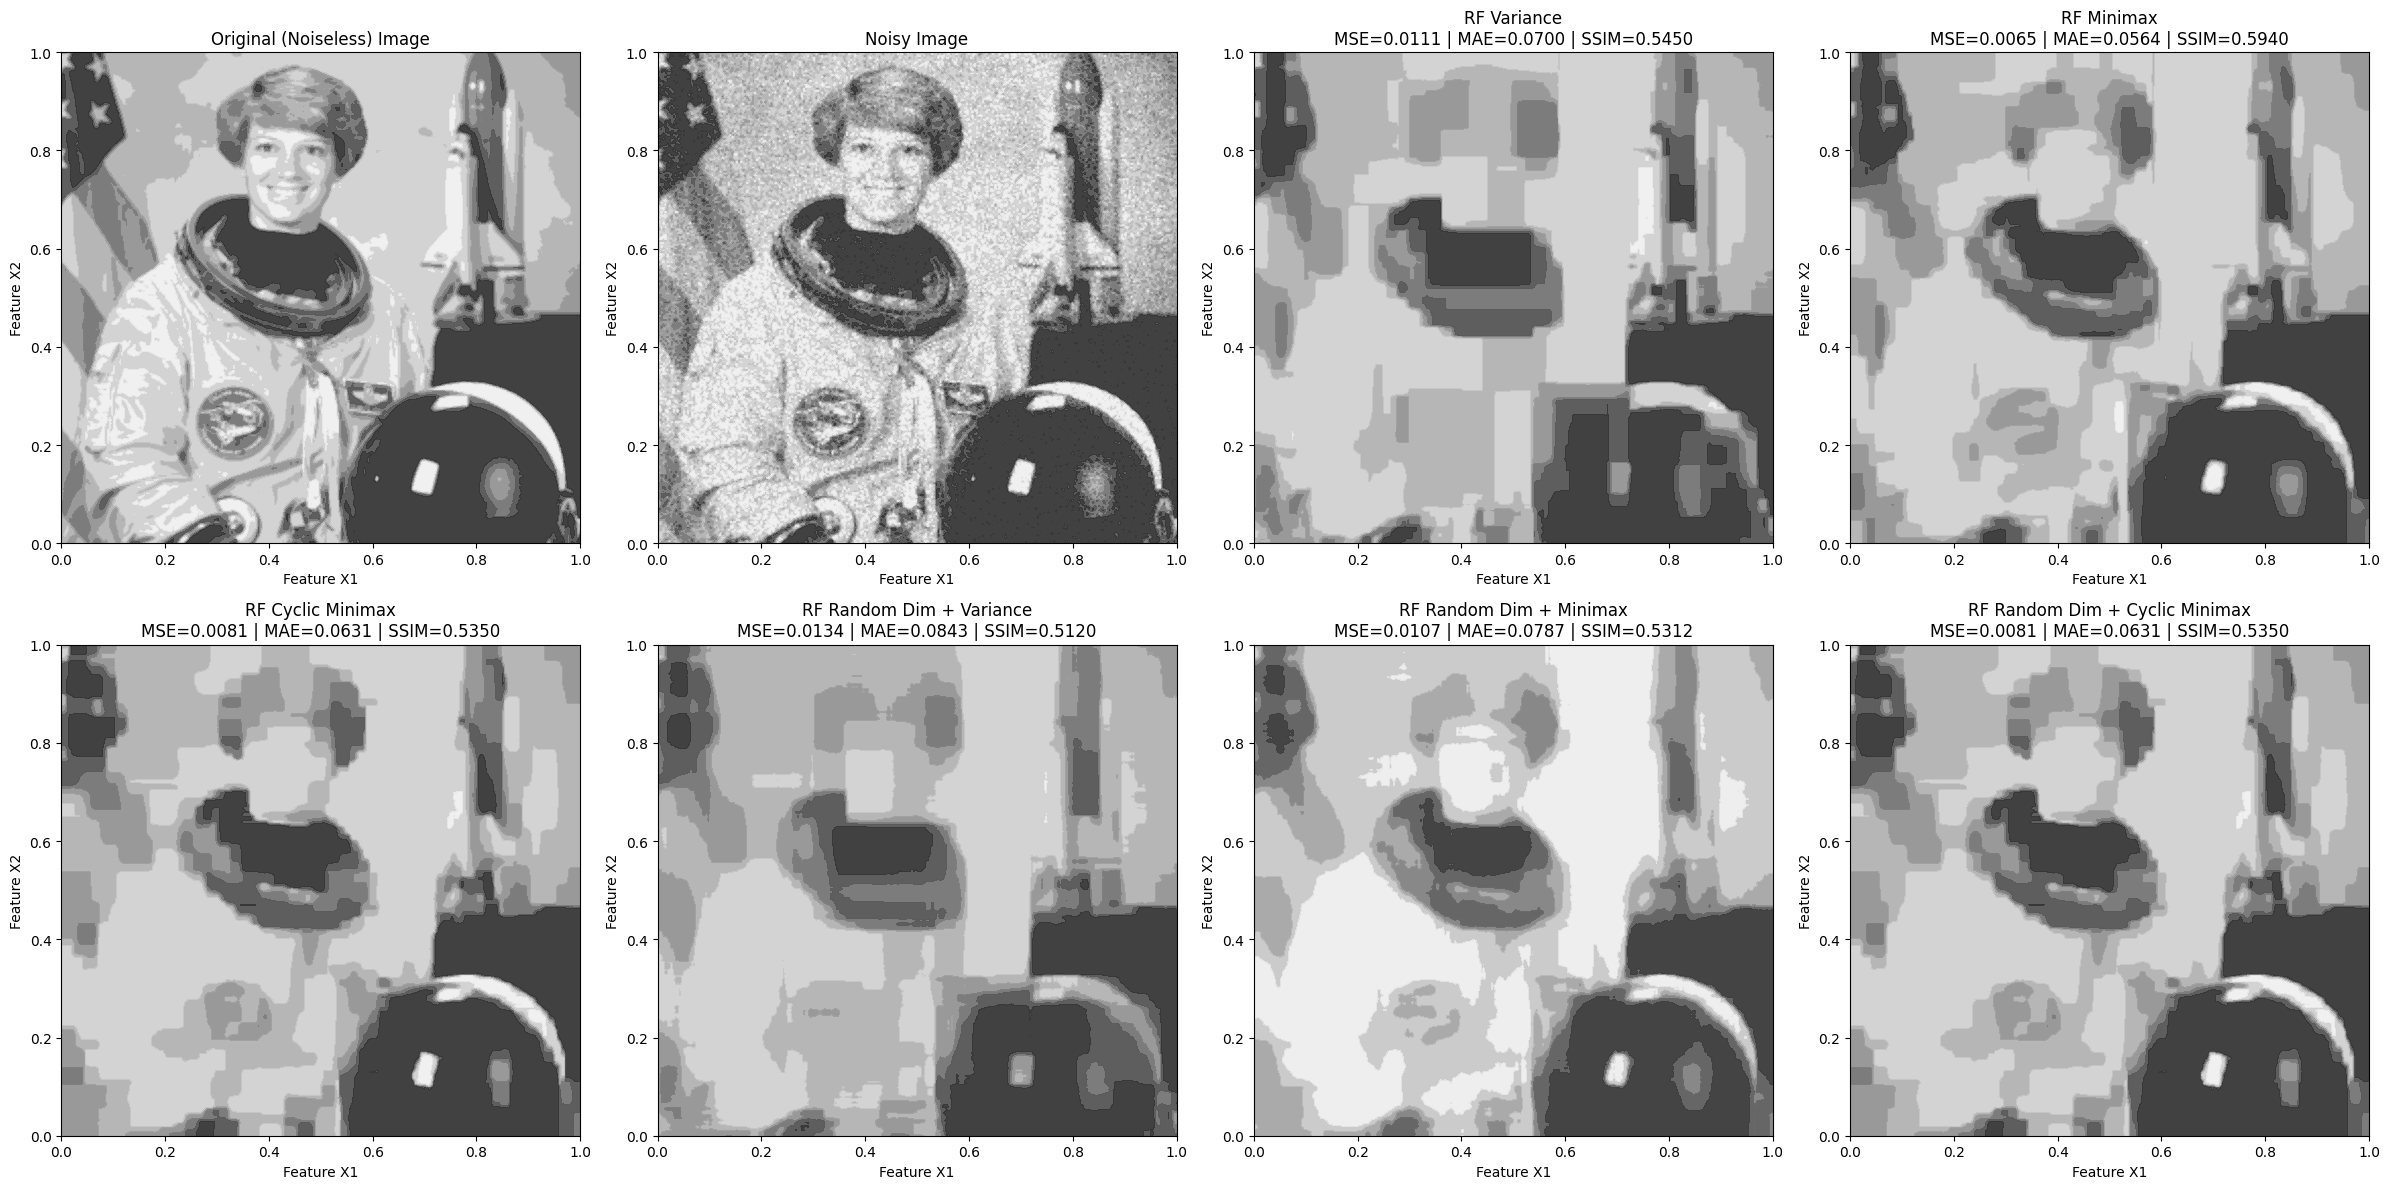


RANDOM FOREST COMPARISON RESULTS
RF_Variance_L2           : MSE=0.0111 | MAE=0.0700 | SSIM=0.5450
RF_Minimax_L2            : MSE=0.0065 | MAE=0.0564 | SSIM=0.5940
RF_Cyclic_Minimax_L2     : MSE=0.0081 | MAE=0.0631 | SSIM=0.5350
RF_Random_Variance       : MSE=0.0134 | MAE=0.0843 | SSIM=0.5120
RF_Random_Minimax        : MSE=0.0107 | MAE=0.0787 | SSIM=0.5312
RF_Random_Cyclic         : MSE=0.0081 | MAE=0.0631 | SSIM=0.5350

PERFORMANCE RANKING (by MSE, lower is better)
 1. RF_Minimax_L2            : MSE=0.0065 | MAE=0.0564 | SSIM=0.5940
 2. RF_Cyclic_Minimax_L2     : MSE=0.0081 | MAE=0.0631 | SSIM=0.5350
 3. RF_Random_Cyclic         : MSE=0.0081 | MAE=0.0631 | SSIM=0.5350
 4. RF_Random_Minimax        : MSE=0.0107 | MAE=0.0787 | SSIM=0.5312
 5. RF_Variance_L2           : MSE=0.0111 | MAE=0.0700 | SSIM=0.5450
 6. RF_Random_Variance       : MSE=0.0134 | MAE=0.0843 | SSIM=0.5120

PERFORMANCE RANKING (by SSIM, higher is better)
 1. RF_Minimax_L2            : MSE=0.0065 | MAE=0.0564 | SSIM=0.59

In [4]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

MY_DEPTH = 10

def lp_minimizer(x, p):
    """
    Find the Lp minimizer for the given 1D vector x and a specified value of p.
    Returns (minimizer, minimal_value).
    """
    def objective(m):
        return np.sum(np.abs(x - m) ** p)
    result = minimize_scalar(objective, method='bounded', bounds=(np.min(x), np.max(x)))
    return result.x, result.fun

class DecisionTreeRegressor:
    def __init__(
        self,
        min_samples_split=2,
        max_depth=float('inf'),
        error_method='variance',
        cyclic_padding=0,
        loss_norm=2,
        random_state=None,
        use_random_features=False,  # New parameter for random feature selection
        n_features_per_split=None   # Number of features to consider per split
    ):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth if isinstance(max_depth, int) else float('inf')
        self.root = None
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm
        self.error_method = error_method
        self.random_state = random_state
        self.use_random_features = use_random_features
        self.n_features_per_split = n_features_per_split
        
        if random_state is not None:
            self.rng = np.random.RandomState(random_state)
        else:
            self.rng = np.random.RandomState()

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None, is_leaf=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left is None and self.right is None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        # Feature selection logic
        if self.use_random_features:
            num_features = X.shape[1]
            if self.n_features_per_split is None:
                n_features = max(1, int(np.sqrt(num_features)))  # Default: sqrt of total features
            else:
                n_features = min(self.n_features_per_split, num_features)
            
            # Randomly sample features for this split
            feature_indices = self.rng.choice(num_features, n_features, replace=False)
        else:
            feature_indices = range(X.shape[1])

        best_feature, best_threshold = self.find_best_split(X, y, feature_indices, depth)

        if best_feature is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, 
                        left=left_subtree, right=right_subtree, data=X, targets=y)

    def find_best_split(self, X, y, feature_indices, depth):
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        
        if self.error_method == 'cyclic_minimax':
            # For cyclic minimax, select feature cyclically
            num_features = X.shape[1]
            feature_index = (self.cyclic_padding + depth) % num_features
            _, threshold, error = self.evaluate_splits(X, y, feature_index, 'minimax')
            return feature_index, threshold
        
        for feature_index in feature_indices:
            if self.error_method == 'xminimizer':
                Xcoord = X[:, feature_index].ravel()
                threshold, error = lp_minimizer(Xcoord, self.loss_norm)
            else:
                _, threshold, error = self.evaluate_splits(X, y, feature_index, self.error_method)
            
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold
        
        return best_feature, best_threshold

    def evaluate_splits(self, X, y, feature_index, error_method):
        thresholds = np.unique(X[:, feature_index])
        min_error = float('inf')
        best_threshold = None
        for threshold in thresholds:
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            error = self.calculate_error(y, left_indices, right_indices, error_method)
            if error < min_error:
                min_error = error
                best_threshold = threshold
        return feature_index, best_threshold, min_error

    def calculate_error(self, y, left_indices, right_indices, error_method):
        # Invalidate trivial splits
        if np.sum(left_indices) <= 1 or np.sum(right_indices) <= 1:
            return np.inf

        if self.loss_norm == 2:
            left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
        else:
            left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
            right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
        
        if error_method in ('minimax', 'cyclic_minimax'):
            return max(left_error, right_error)
        else:  # 'variance'
            return left_error + right_error

    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return np.array(predictions)

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=10, min_samples_split=2, 
                 error_method='variance', loss_norm=2, random_state=None,
                 use_random_features=False, n_features_per_split=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.error_method = error_method
        self.loss_norm = loss_norm
        self.random_state = random_state
        self.use_random_features = use_random_features
        self.n_features_per_split = n_features_per_split
        self.trees = []
        
        if random_state is not None:
            self.rng = np.random.RandomState(random_state)
        else:
            self.rng = np.random.RandomState()

    def fit(self, X, y):
        n_samples = len(X)
        self.trees = []
        
        for i in range(self.n_estimators):
            # Bootstrap sampling
            bootstrap_indices = self.rng.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Create and fit tree with unique random state for each tree
            tree_random_state = self.rng.randint(0, 10000) if self.random_state is not None else None
            tree = DecisionTreeRegressor(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                error_method=self.error_method,
                loss_norm=self.loss_norm,
                random_state=tree_random_state,
                use_random_features=self.use_random_features,
                n_features_per_split=self.n_features_per_split
            )
            tree.root = tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        # Get predictions from all trees
        all_predictions = np.array([tree.predict(X) for tree in self.trees])
        # Return the mean prediction
        return np.mean(all_predictions, axis=0)


# Load and prepare image data (assuming the image loading code from previous script)
np.random.seed(1)
from scipy import ndimage
from skimage import io, color, transform

def load_image(filepath, height=64, width=64):
    # Load the image
    image = io.imread(filepath)[:,:,0]
    
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Resize the image if height and width are provided
    if height is not None and width is not None:
        image = transform.resize(image, (height, width), anti_aliasing=True)
    
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())
    
    return image

def add_noise(image, mean=0, std=1.):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

def calculate_metrics(pred_image, true_image):
    """Calculate MSE, MAE, and SSIM metrics"""
    # Ensure both images are 2D and same shape
    if pred_image.shape != true_image.shape:
        raise ValueError("Images must have the same shape")
    
    # Mean Squared Error
    mse = np.mean((pred_image - true_image) ** 2)
    
    # Mean Absolute Error  
    mae = np.mean(np.abs(pred_image - true_image))
    
    # Structural Similarity Index (SSIM)
    # SSIM expects values in [0,1] range
    ssim_value = ssim(true_image, pred_image, data_range=1.0)
    
    return mse, mae, ssim_value

# Load original image
original_image = load_image('astronaut.jpeg', 256, 256)

# Add noise
noisy_image = add_noise(original_image, 0., 0.1)

# Better visualization
original_image = np.rot90(original_image, k=-1) 
noisy_image = np.rot90(noisy_image, k=-1) 
height, width = original_image.shape

# Generating a 2D grid of features
x1 = np.linspace(0, 1, height)
x2 = np.linspace(0, 1, width)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

y = noisy_image.flatten(order='F')

# Results storage
results = {}

# Prepare the mesh grid for predictions and visualization
X_new = np.c_[X1.ravel(), X2.ravel()]
y_new = original_image.flatten(order='F')

print(f"Training random forests with depth {MY_DEPTH}...")

# Configuration
n_estimators = 50
random_state = 42

# 1. Pure VarianceSplit L2 trees
print("Training Random Forest with pure Variance Split L2 trees...")
rf_variance = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=MY_DEPTH, 
    error_method='variance', 
    loss_norm=2,
    random_state=random_state,
    use_random_features=False
)
rf_variance.fit(X, y)
pred_variance = rf_variance.predict(X_new)
pred_variance_2d = pred_variance.reshape(X1.shape)
true_image_2d = y_new.reshape(X1.shape)
mse_v, mae_v, ssim_v = calculate_metrics(pred_variance_2d, true_image_2d)
results['RF_Variance_L2'] = (pred_variance_2d, mse_v, mae_v, ssim_v)

# 2. Pure MinimaxSplit L2 trees
print("Training Random Forest with pure Minimax Split L2 trees...")
rf_minimax = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=MY_DEPTH, 
    error_method='minimax', 
    loss_norm=2,
    random_state=random_state,
    use_random_features=False
)
rf_minimax.fit(X, y)
pred_minimax = rf_minimax.predict(X_new)
pred_minimax_2d = pred_minimax.reshape(X1.shape)
mse_m, mae_m, ssim_m = calculate_metrics(pred_minimax_2d, true_image_2d)
results['RF_Minimax_L2'] = (pred_minimax_2d, mse_m, mae_m, ssim_m)

# 3. Pure cyclic Minimax L2 trees
print("Training Random Forest with pure Cyclic Minimax L2 trees...")
rf_cyclic = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=MY_DEPTH, 
    error_method='cyclic_minimax', 
    loss_norm=2,
    random_state=random_state,
    use_random_features=False
)
rf_cyclic.fit(X, y)
pred_cyclic = rf_cyclic.predict(X_new)
pred_cyclic_2d = pred_cyclic.reshape(X1.shape)
mse_c, mae_c, ssim_c = calculate_metrics(pred_cyclic_2d, true_image_2d)
results['RF_Cyclic_Minimax_L2'] = (pred_cyclic_2d, mse_c, mae_c, ssim_c)

# 4. Random features + VarianceSplit
print("Training Random Forest with random features + Variance Split...")
rf_rand_variance = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=MY_DEPTH, 
    error_method='variance', 
    loss_norm=2,
    random_state=random_state,
    use_random_features=True,
    n_features_per_split=1  # Consider 1 random feature per split
)
rf_rand_variance.fit(X, y)
pred_rand_variance = rf_rand_variance.predict(X_new)
pred_rand_variance_2d = pred_rand_variance.reshape(X1.shape)
mse_rv, mae_rv, ssim_rv = calculate_metrics(pred_rand_variance_2d, true_image_2d)
results['RF_Random_Variance'] = (pred_rand_variance_2d, mse_rv, mae_rv, ssim_rv)

# 5. Random features + MinimaxSplit
print("Training Random Forest with random features + Minimax Split...")
rf_rand_minimax = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=MY_DEPTH, 
    error_method='minimax', 
    loss_norm=2,
    random_state=random_state,
    use_random_features=True,
    n_features_per_split=1
)
rf_rand_minimax.fit(X, y)
pred_rand_minimax = rf_rand_minimax.predict(X_new)
pred_rand_minimax_2d = pred_rand_minimax.reshape(X1.shape)
mse_rm, mae_rm, ssim_rm = calculate_metrics(pred_rand_minimax_2d, true_image_2d)
results['RF_Random_Minimax'] = (pred_rand_minimax_2d, mse_rm, mae_rm, ssim_rm)

# 6. Random features + cyclic Minimax
print("Training Random Forest with random features + Cyclic Minimax Split...")
rf_rand_cyclic = RandomForestRegressor(
    n_estimators=n_estimators, 
    max_depth=MY_DEPTH, 
    error_method='cyclic_minimax', 
    loss_norm=2,
    random_state=random_state,
    use_random_features=True,
    n_features_per_split=1
)
rf_rand_cyclic.fit(X, y)
pred_rand_cyclic = rf_rand_cyclic.predict(X_new)
pred_rand_cyclic_2d = pred_rand_cyclic.reshape(X1.shape)
mse_rc, mae_rc, ssim_rc = calculate_metrics(pred_rand_cyclic_2d, true_image_2d)
results['RF_Random_Cyclic'] = (pred_rand_cyclic_2d, mse_rc, mae_rc, ssim_rc)

# Plotting the results
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Original and noisy images
axes[0, 0].contourf(X1, X2, y_new.reshape(X1.shape), cmap='gray', alpha=0.8)
axes[0, 0].set_title('Original (Noiseless) Image')
axes[0, 0].set_xlabel('Feature X1')
axes[0, 0].set_ylabel('Feature X2')

axes[0, 1].contourf(X1, X2, y.reshape(X1.shape), cmap='gray', alpha=0.8)
axes[0, 1].set_title('Noisy Image')
axes[0, 1].set_xlabel('Feature X1')
axes[0, 1].set_ylabel('Feature X2')

# Random Forest results
plot_data = [
    ('RF_Variance_L2', 'RF Variance'),
    ('RF_Minimax_L2', 'RF Minimax'),
    ('RF_Cyclic_Minimax_L2', 'RF Cyclic Minimax'),
    ('RF_Random_Variance', 'RF Random Dim + Variance'),
    ('RF_Random_Minimax', 'RF Random Dim + Minimax'),
    ('RF_Random_Cyclic', 'RF Random Dim + Cyclic Minimax')
]

positions = [(0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]

for i, (key, title) in enumerate(plot_data):
    row, col = positions[i]
    prediction, mse, mae, ssim_val = results[key]
    
    im = axes[row, col].contourf(X1, X2, prediction, cmap='gray', alpha=0.8)
    axes[row, col].set_title(f'{title}\nMSE={mse:.4f} | MAE={mae:.4f} | SSIM={ssim_val:.4f}')
    axes[row, col].set_xlabel('Feature X1')
    axes[row, col].set_ylabel('Feature X2')

plt.tight_layout()
plt.show()

# Print summary of results
print("\n" + "="*80)
print("RANDOM FOREST COMPARISON RESULTS")
print("="*80)
for key, (_, mse, mae, ssim_val) in results.items():
    print(f"{key:25s}: MSE={mse:.4f} | MAE={mae:.4f} | SSIM={ssim_val:.4f}")

# Print relative performance (sorted by MSE)
print("\n" + "="*80)
print("PERFORMANCE RANKING (by MSE, lower is better)")
print("="*80)
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for i, (key, (_, mse, mae, ssim_val)) in enumerate(sorted_results):
    print(f"{i+1:2d}. {key:25s}: MSE={mse:.4f} | MAE={mae:.4f} | SSIM={ssim_val:.4f}")

# Print SSIM ranking (higher is better)
print("\n" + "="*80)
print("PERFORMANCE RANKING (by SSIM, higher is better)")
print("="*80)
sorted_results_ssim = sorted(results.items(), key=lambda x: x[1][3], reverse=True)
for i, (key, (_, mse, mae, ssim_val)) in enumerate(sorted_results_ssim):
    print(f"{i+1:2d}. {key:25s}: MSE={mse:.4f} | MAE={mae:.4f} | SSIM={ssim_val:.4f}")